In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score, root_mean_squared_error
import yfinance as yf
import seaborn as sns
import matplotlib.dates as mdates
import warnings
from datetime import datetime, timedelta
warnings.filterwarnings("ignore")

Import IHSG Data

In [38]:
start_date = "2020-01-01"
end_date = datetime.now().strftime("%Y-%m-%d")

pd.set_option('display.max_rows', None)

# Read dataframe from yfinance
df = yf.Ticker("POLA.JK")
df = df.history(start=start_date, end=end_date)
del df["Dividends"]
del df["Stock Splits"]

forecastData = df.copy()
df.tail(30)

,Open,High,Low,Close,Volume
Date,,,,,
2025-11-21 00:00:00+07:00,34.0,37.0,34.0,37.0,3193200
2025-11-24 00:00:00+07:00,37.0,37.0,37.0,37.0,1332500
2025-11-25 00:00:00+07:00,34.0,36.0,34.0,36.0,1029000
2025-11-26 00:00:00+07:00,36.0,36.0,35.0,35.0,1282200
2025-11-27 00:00:00+07:00,35.0,35.0,34.0,34.0,2157300
2025-11-28 00:00:00+07:00,34.0,35.0,34.0,35.0,2074400
2025-12-01 00:00:00+07:00,36.0,38.0,36.0,38.0,8240800
2025-12-02 00:00:00+07:00,41.0,41.0,41.0,41.0,1633300
2025-12-03 00:00:00+07:00,45.0,45.0,45.0,45.0,3260000


# Feature Engineering

In [39]:
# YoY Growth (price-based)
df["close_yoy_growth"] = df["Close"].pct_change(periods=252) * 100
df["volume_yoy_growth"] = df["Volume"].pct_change(periods=252) * 100

In [40]:
# Rolling Mean & Std Dev (Votalitiy & trend)

windows = [5, 20, 60]

for w in windows:
    df[f"close_ma_{w}"] = df["Close"].rolling(window=w).mean()
    df[f"close_std_{w}"] = df["Close"].rolling(window=w).std()
    df[f"volume_ma_{w}"] = df["Volume"].rolling(window=w).mean()

In [41]:
# Z-Score (Normalization for ML)

for w in [20, 60]:
    df[f"close_zscore_{w}"] = (df["Close"] - df["Close"].rolling(window=w).mean()) / df["Close"].rolling(window=w).std()
    df[f"volume_zscore_{w}"] = (df["Volume"] - df["Volume"].rolling(window=w).mean()) / df["Volume"].rolling(window=w).std()

In [42]:
# Rank-Based Feature (Robust & RL-friendly)
df["close_rank_20"] = df["Close"].rolling(window=20).apply(lambda x: pd.Series(x).rank(pct=True).iloc[-1])
df["volume_rank_20"] = df["Volume"].rolling(window=20).apply(lambda x: pd.Series(x).rank(pct=True).iloc[-1])

In [43]:
# Interaction Feature (Signal Amplifier)

# Momentum x volume
df["momentum_volume"] = (df["Close"].pct_change(5) * df["Volume"].pct_change(5))

# Trend x volatility
df["trend_volatility"] = (df["Close"].rolling(window=20).mean() / df["Close"].rolling(window=20).std())

# Z-score × YoY Growth
df["zscore_yoy_interaction"] = df["close_zscore_20"] * df["close_yoy_growth"]

# Final Cleaning

In [44]:
pd.set_option('display.max_columns', None)
df = df.dropna()
df.tail(30)

,Open,High,Low,Close,Volume,close_yoy_growth,volume_yoy_growth,close_ma_5,close_std_5,volume_ma_5,close_ma_20,close_std_20,volume_ma_20,close_ma_60,close_std_60,volume_ma_60,close_zscore_20,volume_zscore_20,close_zscore_60,volume_zscore_60,close_rank_20,volume_rank_20,momentum_volume,trend_volatility,zscore_yoy_interaction
Date,,,,,,,,,,,,,,,,,,,,,,,,,
2025-11-20 00:00:00+07:00,35.0,35.0,33.0,34.0,364600,142.857143,2.600741e+03,34.8,0.836660,1471340.0,35.80,1.436370,1781950.0,39.066667,10.227690,6.976287e+06,-1.253159,-1.474354,-0.495387,-0.608099,0.125,0.050,0.055937,24.923946,-179.022753
2025-11-21 00:00:00+07:00,34.0,37.0,34.0,37.0,3193200,164.285714,6.198225e+03,35.0,1.224745,1901000.0,35.80,1.436370,1892285.0,39.200000,10.146052,7.010810e+06,0.835440,1.312200,-0.216833,-0.351624,0.750,0.900,0.057111,24.923946,137.250778
2025-11-24 00:00:00+07:00,37.0,37.0,37.0,37.0,1332500,164.285714,-5.007868e+01,35.6,1.341641,1544200.0,35.90,1.447321,1798805.0,39.350000,10.043676,7.007683e+06,0.760025,-0.491564,-0.233978,-0.522638,0.725,0.450,-0.050509,24.804456,124.861271
2025-11-25 00:00:00+07:00,34.0,36.0,34.0,36.0,1029000,157.142857,2.609260e+02,35.8,1.303840,1423280.0,35.80,1.361114,1649910.0,39.516667,9.900337,6.912108e+06,0.146938,-0.769487,-0.355207,-0.540424,0.575,0.150,-0.010574,26.301983,23.090328
2025-11-26 00:00:00+07:00,36.0,36.0,35.0,35.0,1282200,169.230769,5.972268e+02,35.8,1.303840,1440300.0,35.70,1.341641,1583650.0,39.700000,9.708113,6.767680e+06,-0.521749,-0.387446,-0.484131,-0.503134,0.400,0.500,0.000000,26.609209,-88.296018
2025-11-27 00:00:00+07:00,35.0,35.0,34.0,34.0,2157300,142.857143,1.702143e+04,35.8,1.303840,1798840.0,35.70,1.341641,1592285.0,39.866667,9.517988,6.710032e+06,-1.267105,0.720989,-0.616377,-0.416995,0.125,0.850,0.000000,26.609209,-181.015027
2025-11-28 00:00:00+07:00,34.0,35.0,34.0,35.0,2074400,169.230769,4.185950e+03,35.4,1.140175,1575080.0,35.75,1.292692,1605865.0,40.050000,9.310874,5.590665e+06,-0.580185,0.593206,-0.542377,-0.487487,0.375,0.800,0.018939,27.655466,-98.185087
2025-12-01 00:00:00+07:00,36.0,38.0,36.0,38.0,8240800,216.666667,5.981771e+03,35.6,1.516575,2956740.0,35.90,1.372665,1947110.0,40.250000,9.131107,5.379975e+06,1.529870,3.750279,-0.246410,0.412329,0.950,1.000,0.140121,26.153495,331.471874
2025-12-02 00:00:00+07:00,41.0,41.0,41.0,41.0,1633300,241.666667,9.661227e+02,36.6,2.880972,3077600.0,36.05,1.731291,1927515.0,40.466667,8.988631,5.171930e+06,2.859138,-0.175178,0.059334,-0.515948,1.000,0.650,0.081565,20.822612,690.958378


Close Price Visualitation

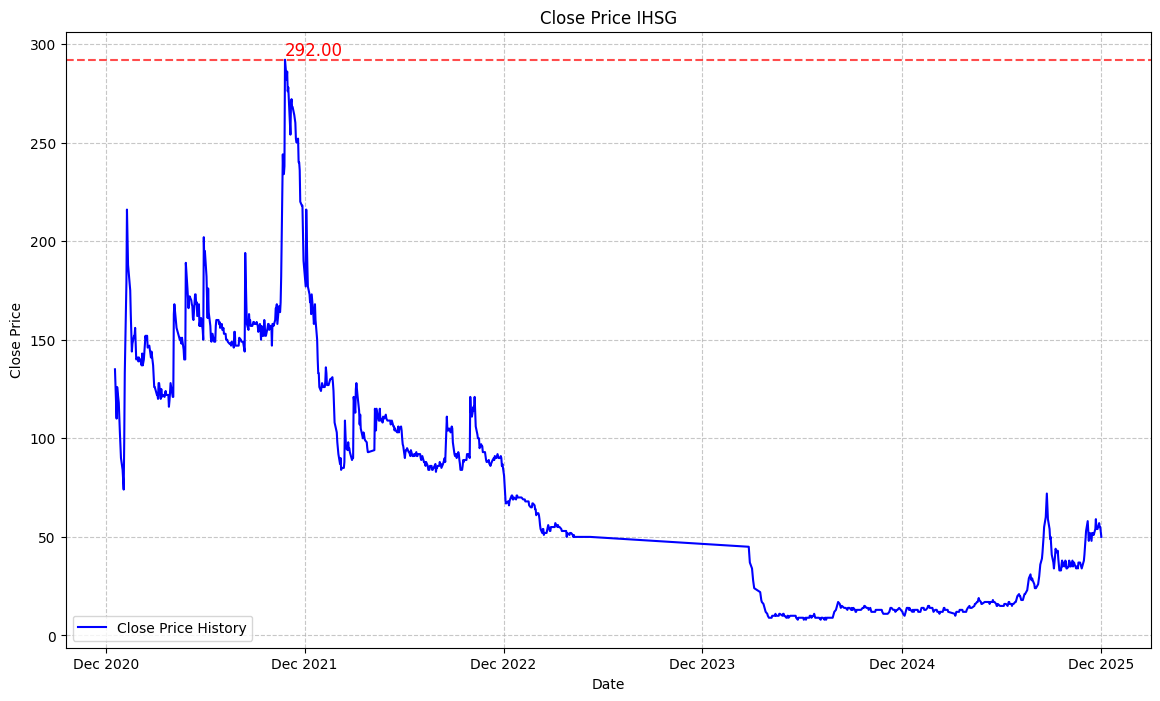

In [45]:
# Close price visualitation

plt.figure(figsize=(14, 8))
sns.lineplot(data=df, x=df.index, y='Close', label='Close Price History', color='blue')

max_price = df['Close'].max()
max_price_date = df['Close'].idxmax()

# Annotate the hight price
plt.annotate(f'{max_price:.2f}',
             xy=(max_price_date, max_price),
             xytext=(max_price_date, max_price + 2),
             fontsize=12, color='red')

plt.axhline(max_price, linestyle='--', color='red', alpha=0.7)
plt.title('Close Price IHSG')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

Preprocessing

In [46]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['Close'].values.reshape(-1, 1))
scaled_data

array([[0.4471831 ],
       [0.41549296],
       [0.38732394],
       ...,
       [0.16549296],
       [0.16549296],
       [0.14788732]])

In [47]:
def create_sequences(df, sequence_length):
    sequences = []
    labels = []
    for i in range(len(df) - sequence_length):
        sequences.append(df[i:i + sequence_length])
        labels.append(df[i + sequence_length, 0])
    return np.array(sequences), np.array(labels)

In [48]:
sequence_length = 30

train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

In [49]:
X_train

array([[[0.4471831 ],
        [0.41549296],
        [0.38732394],
        ...,
        [0.49295775],
        [0.46478873],
        [0.46830986]],

       [[0.41549296],
        [0.38732394],
        [0.35915493],
        ...,
        [0.46478873],
        [0.46830986],
        [0.46126761]],

       [[0.38732394],
        [0.35915493],
        [0.41549296],
        ...,
        [0.46830986],
        [0.46126761],
        [0.46830986]],

       ...,

       [[0.01408451],
        [0.01760563],
        [0.02112676],
        ...,
        [0.02464789],
        [0.02464789],
        [0.02112676]],

       [[0.01760563],
        [0.02112676],
        [0.02112676],
        ...,
        [0.02464789],
        [0.02112676],
        [0.02112676]],

       [[0.02112676],
        [0.02112676],
        [0.01760563],
        ...,
        [0.02112676],
        [0.02112676],
        [0.02112676]]])

Training Data

In [50]:
model = Sequential()

# First Layer lSTM
model.add(Input(shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

# Second Layer LSTM
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Dense Layer
model.add(Dense(units=25))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [51]:
import tensorflow as tf

callbacks = (
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )
)

history = model.fit(X_train, y_train, epochs=100, batch_size=126, validation_data=(X_test, y_test), callbacks=callbacks)

Epoch 1/100
7/7 [==============================] - 2s 99ms/step - loss: 0.0648 - val_loss: 0.0181
Epoch 2/100
7/7 [==============================] - 0s 34ms/step - loss: 0.0194 - val_loss: 0.0054
Epoch 3/100
7/7 [==============================] - 0s 17ms/step - loss: 0.0106 - val_loss: 0.0012
Epoch 4/100
7/7 [==============================] - 0s 17ms/step - loss: 0.0067 - val_loss: 0.0021
Epoch 5/100
7/7 [==============================] - 0s 26ms/step - loss: 0.0054 - val_loss: 5.8462e-04
Epoch 6/100
7/7 [==============================] - 0s 29ms/step - loss: 0.0038 - val_loss: 8.6108e-04
Epoch 7/100
7/7 [==============================] - 0s 31ms/step - loss: 0.0035 - val_loss: 6.0472e-04
Epoch 8/100
7/7 [==============================] - 0s 32ms/step - loss: 0.0035 - val_loss: 6.7735e-04
Epoch 9/100
7/7 [==============================] - 0s 29ms/step - loss: 0.0036 - val_loss: 5.5480e-04
Epoch 10/100
7/7 [==============================] - 0s 27ms/step - loss: 0.0036 - val_loss: 5.1921

Model Evaluation

In [52]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))
mse = mean_squared_error(y_test_scaled, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_scaled, predictions)
mape = mean_absolute_percentage_error(y_test_scaled, predictions) * 100

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R2 Score: {r2}")
print(f"Mean Absolute Percentage Error: {mape}%")

6/6 [==============================] - 0s 13ms/step
Mean Squared Error: 24.398113243592782
Root Mean Squared Error: 4.939444629064363
R2 Score: 0.886468712061781
Mean Absolute Percentage Error: 8.514624160905756%


Prediction Future IHSG Price in 1 Month

In [53]:
# we choose last 30 days or data ke belakang which the reasons use (-) in sequence_length
last_30_days = df['Close'][-sequence_length:].values.reshape(-1, 1)
last_30_days_scaled = scaler.transform(last_30_days)

X_predict = []
X_predict.append(last_30_days_scaled)

X_predict = np.array(X_predict)
X_predict = np.reshape(X_predict, (X_predict.shape[0], X_predict.shape[1], 1))
predicted_price = model.predict(X_predict)
predicted_price = scaler.inverse_transform(predicted_price)

print(f"Predicted IHSG Price: {predicted_price[0][0]}")

1/1 [==============================] - 0s 22ms/step
Predicted IHSG Price: 54.279212951660156


In [54]:
future_days = 30

last_30_days = df['Close'][-sequence_length:].values.reshape(-1, 1)
last_30_days_scaled = scaler.transform(last_30_days)
future_predictions = []

for i in range(future_days):
    X_predict = []
    X_predict.append(last_30_days_scaled)
    X_predict = np.array(X_predict)
    X_predict = np.reshape(X_predict, (X_predict.shape[0], X_predict.shape[1], 1))

    predicted_price = model.predict(X_predict)
    predicted_price_unscaled = scaler.inverse_transform(predicted_price)

    future_predictions.append(predicted_price_unscaled[0, 0])

    new_scaled_data = np.append(last_30_days_scaled[1:], predicted_price, axis=0)
    last_30_days_scaled = new_scaled_data.reshape(-1, 1)

last_historical_date = df.index[-1].tz_localize(None).normalize()

future_dates_all = pd.date_range(
    start = last_historical_date,
    periods = future_days * 2,
    freq = 'B'
)


future_dates = future_dates_all[future_dates_all > last_historical_date][:future_days]

future_predictions_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted Price IHSG': future_predictions})

1/1 [==============================] - 0s 14ms/step


Visualitation IHSG Predictions

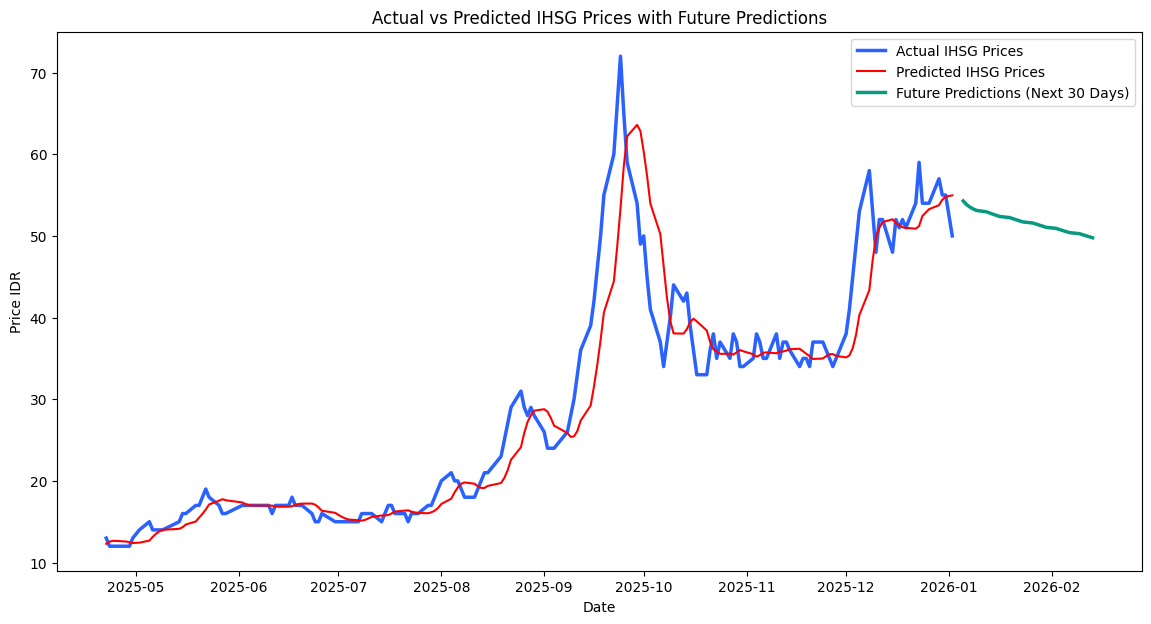

In [55]:
plt.figure(figsize=(14, 7))

plt.plot(df.index[-len(y_test_scaled):], y_test_scaled, label='Actual IHSG Prices', color='#2962ff', linewidth=2.5)
plt.plot(df.index[-len(y_test_scaled):], predictions, label='Predicted IHSG Prices', color='red', linewidth=1.5)
plt.plot(future_dates, future_predictions, label='Future Predictions (Next 30 Days)', color='#089981', linewidth=2.5)

plt.title('Actual vs Predicted IHSG Prices with Future Predictions')
plt.xlabel('Date')
plt.ylabel('Price IDR')
plt.legend()
plt.show()

In [56]:
# Transforming into DataFrame with pandas
future_predictions_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted Price IHSG': future_predictions
})

future_predictions_df.head(15)

,Date,Predicted Price IHSG
0,2026-01-05,54.279213
1,2026-01-06,53.836170
2,2026-01-07,53.531937
3,2026-01-08,53.303444
4,2026-01-09,53.116291
5,2026-01-12,52.951710
6,2026-01-13,52.799488
7,2026-01-14,52.654377
8,2026-01-15,52.513721
9,2026-01-16,52.375854


In [57]:
# calculate percentage change from the last actual close price
last_actual_price = df['Close'].iloc[-1]
percentage_change = ((future_predictions_df['Predicted Price IHSG'].iloc[-1] - last_actual_price) / last_actual_price) * 100

# Determine profit or loss
status = "profit" if percentage_change > 0 else "loss"

# print the percentage prediction
print(f"Percentage prediction for 30 days is: {status} {abs(percentage_change):.2f}%")

Percentage prediction for 30 days is: loss 0.46%
